# 1. Logistic Regression
- radius 변수를 기준으로 양성/음성 분류하는 모델 만들기
- 시각화
- radius= 20, 0.1일때의 결과 해석하기

In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt # 기본적인 그래프 그리기
import seaborn as sns # Matplotlib을 기반으로 다양한 색상 테마와 통계용 차트 등의 기능을 추가한 시각화 패키지

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/session07')

In [0]:
df=load_breast_cancer()

In [0]:
print(df.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [0]:
df['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [0]:
df['target_names'] #m: 음성(악성) 암 (0) / b: 양성 암 x (1) / 0,1,2 0-> 1/ 1,2 ->0 (y==0).type(int)

array(['malignant', 'benign'], dtype='<U9')

In [0]:
df['target'].shape

(569,)

In [0]:
x_train=df['data'][:,0].reshape(-1,1)
y_train=df['target']

In [0]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리
#기존에 주어진 학습데이터의 양이 너무 적어 0.1로 조정
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size=0.1,
                                                    random_state=1237)


In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
log_reg = LogisticRegression(random_state=1237)
log_reg.fit(x_train,y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1237, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
log_reg.predict_proba([[20]]) #순서대로 prob(b=0), prob(m=1) y 0,1 -> 1,0 
#양성일 확률이 60%

array([[0.39552504, 0.60447496]])

In [0]:
log_reg.predict_proba([[0.1]]) #순서대로 prob(b=0), prob(m=1)
#양성일 확률이 97%

array([[0.00683185, 0.99316815]])

In [0]:
pd.DataFrame(x_train).describe()

,0
count,512.000000
mean,19.382187
std,4.354861
min,9.710000
25%,16.177500
50%,18.880000
75%,21.917500
max,39.280000


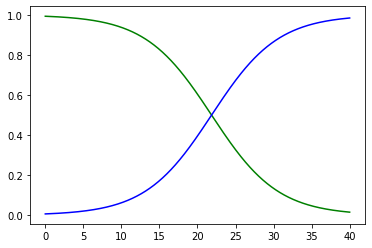

In [0]:
#학습 데이터의 x_train값들의 분포를 살펴보았더니, [9.7,39.3] 사이에 분포하고 있었다.
#이를 반영하여 0~40까지의 랜덤값들에 대한 예측을 해본다
X_new = np.linspace(0, 40, 1000).reshape(-1,1) #0부터 40사이의 천개의 값
y_prob = log_reg.predict_proba(X_new) #X_new를 넣어서 앞에 만든 모델로 예측하기
plt.plot(X_new, y_prob[:,1], color='green', label='Malignant')
plt.plot(X_new, y_prob[:,0], color='blue', label='Benign') 
plt.legend() 

In [0]:
y_pred=log_reg.predict(x_test)

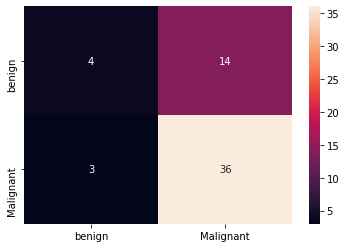

In [0]:
### 오답/정답 시각화를 위한 간단한 히트맵
# 정답 클래스는 행(row)으로 예측한 클래스는 열(column)로 나타낸다
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred)
                  , columns=['benign', 'Malignant']
                  , index=['benign', 'Malignant'])
sns.heatmap(cm, annot=True, fmt='d') 

- test set에서,
- 5개의 음성 암세포중, 2개는 양성으로 예측하였으며
- 52개의 양성 암세포중, 15개를 음성으로 예측하여
- 예측의 정확성이 아쉬운 모델이었다.
-> train/test set split으로 학습데이터의 개수를 줄여 정확성이 떨어진 것으로 보인다

# 2. SVM
- non linear kernel을 사용하여 hyperparameter tuning
- 최종 highest acc score model 

In [0]:
df = pd.read_csv('AB_NYC_2019.csv', encoding='utf-8') 
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [0]:
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
df.shape, our_set.shape #맨하튼, 브루클린으로 줄여도 그렇게 데이터가 줄지 않음.

((48895, 16), (41765, 16))

In [0]:
our_set = our_set.replace('Brooklyn', 0).replace('Manhattan', 1) 

In [0]:
x = pd.get_dummies(our_set['room_type']) #원핫인코딩
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(x, left_index=True, right_index=True, how='left').reset_index()
combined.head()

,index,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,0,149,1,9,0.21,0,1,0
1,1,1,225,1,45,0.38,1,0,0
2,2,1,150,3,0,NaN,0,1,0
3,3,0,89,1,270,4.64,1,0,0
4,4,1,80,10,9,0.10,1,0,0


In [0]:
final = combined.drop(columns=['index']).dropna() #index컬럼 필요 없으니까 index 죽이고 na도 drop
final.shape

(33079, 8)

In [0]:
bk = len(final[final['neighbourhood_group']==0])
mh = len(final[final['neighbourhood_group']==1])
tt = len(final)
print("브루클린 건은 {0}건({2:.1f}%), 맨하탄 건은 {1}건({3:.1f}%)이네요.".format(bk, mh, 100*bk/tt, 100*mh/tt))

브루클린 건은 16447건(49.7%), 맨하탄 건은 16632건(50.3%)이네요.


## modeling

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=1237)


In [0]:
### SVM 모델 수립 #linear kernel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,MaxAbsScaler
#StandardScaler: 평균이0, 분산이1이 되도록 변환
#RobustScaler: 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환
#MinMaxScaler: 최대값이 각각 1, 최소값이 0이 되도록 변환
#MaxAbsScaler: 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환
from sklearn.svm import LinearSVC #선형 kernel을 사용하는 svm
import time
from sklearn.preprocessing import PolynomialFeatures

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Baseline

In [0]:
random_seed=1237

In [0]:
#baseline
### 학습 진행 (linear)
svm = Pipeline([ #파이프라인은 연속된 변환을 순서대로 처리할 수 있도록 도와주는 함수
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss = "hinge",random_state=random_seed))
])

t0 = time.time()
svm.fit(X_train, y_train)
elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

### 학습된 모델로 분류 예측
prediction = svm.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction)#맞는지 아닌지 비교해보겠다는거에요
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

걸린시간은 3.65초입니다.
Mean accuracy score: 62.3%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
def choose_scaler(scaler):
    svm= Pipeline([
        ("scaler", scaler),
        ("svm_clf", SVC(kernel='rbf', C=10.0, random_state=random_seed, gamma=0.10))
    ])
    print(scaler,"Scaler")
    t0 = time.time()
    svm.fit(X_train, y_train)
    elapsed = time.time()-t0
    print("걸린시간은 {:.2f}초입니다.".format(elapsed))
    prediction = svm.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    print(f'Mean accuracy score: {100*accuracy:.3}%')

In [0]:
choose_scaler(StandardScaler())

StandardScaler(copy=True, with_mean=True, with_std=True) Scaler
걸린시간은 21.47초입니다.
Mean accuracy score: 63.4%


In [0]:
choose_scaler(RobustScaler())

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True) Scaler
걸린시간은 22.79초입니다.
Mean accuracy score: 63.8%


In [0]:
choose_scaler(MinMaxScaler())

MinMaxScaler(copy=True, feature_range=(0, 1)) Scaler
걸린시간은 22.14초입니다.
Mean accuracy score: 58.5%


In [0]:
choose_scaler(MaxAbsScaler())

MaxAbsScaler(copy=True) Scaler
걸린시간은 22.03초입니다.
Mean accuracy score: 58.5%


### scaler 결정
- robustscaler가 가장 좋은 성능을 보여 선택
- RobustScaler: 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환
- -> 이상치에 영향을 줄이는 scaler가 성능이 가장 우수했던 것으로 보아, 데이터에 이상치가 많은 영향을 주고있다고 예상

## modifying models
- rbf: RBF (Radial Basis Function (방사 기저 함수)) 커널 함수 사용, 비선형 SVM, 디폴트
- gamma를 증가시키면 일반적으로 훈련 샘플의 영향력이 증가하고, 결정경계가 더욱 부드러워지게 된다


In [0]:
random_seed=1237

In [0]:
def modifying_models(c_val,g_val):
    svm = Pipeline([ #파이프라인은 연속된 변환을 순서대로 처리할 수 있도록 도와주는 함수
    ("scaler", RobustScaler()),
    ("svm_clf", SVC(kernel='rbf', C=c_val, random_state=random_seed, gamma=g_val))])

    t0 = time.time()
    svm.fit(X_train, y_train)
    elapsed = time.time()-t0
    print("걸린시간은 {:.2f}초입니다.".format(elapsed))
    prediction = svm.predict(X_test)
    ### 채점
    accuracy = accuracy_score(y_test, prediction)
    ### 성적 발표
    print(f'Mean accuracy score: {100*accuracy:.3}%')
    print("with c value: ", c_val)
    print("with gamma value: ", g_val)

In [0]:
gamma=0.01
from tqdm import tqdm
c_values = np.linspace(10, 100, 10).tolist()
for c in tqdm(c_values):
    modifying_models(c,gamma)
    

  0%|          | 0/10 [00:00<?, ?it/s]

걸린시간은 20.97초입니다.


 10%|█         | 1/10 [00:24<03:44, 24.95s/it]

Mean accuracy score: 63.5%
with c value:  10.0
with gamma value:  0.01
걸린시간은 21.73초입니다.


 20%|██        | 2/10 [00:50<03:21, 25.20s/it]

Mean accuracy score: 63.7%
with c value:  20.0
with gamma value:  0.01
걸린시간은 22.19초입니다.


 30%|███       | 3/10 [01:16<02:58, 25.46s/it]

Mean accuracy score: 63.6%
with c value:  30.0
with gamma value:  0.01
걸린시간은 21.84초입니다.


 40%|████      | 4/10 [01:42<02:33, 25.55s/it]

Mean accuracy score: 63.7%
with c value:  40.0
with gamma value:  0.01
걸린시간은 21.92초입니다.


 50%|█████     | 5/10 [02:08<02:08, 25.64s/it]

Mean accuracy score: 63.6%
with c value:  50.0
with gamma value:  0.01
걸린시간은 22.36초입니다.


 60%|██████    | 6/10 [02:34<01:43, 25.80s/it]

Mean accuracy score: 63.7%
with c value:  60.0
with gamma value:  0.01
걸린시간은 22.34초입니다.


 70%|███████   | 7/10 [03:00<01:17, 25.89s/it]

Mean accuracy score: 63.7%
with c value:  70.0
with gamma value:  0.01
걸린시간은 22.16초입니다.


 80%|████████  | 8/10 [03:26<00:51, 25.94s/it]

Mean accuracy score: 63.7%
with c value:  80.0
with gamma value:  0.01
걸린시간은 22.91초입니다.


 90%|█████████ | 9/10 [03:53<00:26, 26.16s/it]

Mean accuracy score: 63.7%
with c value:  90.0
with gamma value:  0.01
걸린시간은 23.22초입니다.


100%|██████████| 10/10 [04:20<00:00, 26.04s/it]

Mean accuracy score: 63.7%
with c value:  100.0
with gamma value:  0.01


In [0]:
#결과를 보면 c값이 상승할 수록 정확도가 상승하나, 그 증가폭이 미미하디.
#또한 c값에 비례하여 iteration 시간도 증가하는 것을 알 수 있다.
# c=20이후에 정확성이 거의 증가하지 않는 것을 통해, 최적의 c값을 40으로 설정한다. ### ?? 40은 오타였던 것이군요.

In [0]:
c=10
from tqdm import tqdm
g_values = np.linspace(0.001,0.1, 5).tolist()
for g in tqdm(g_values):
    modifying_models(c,g)
    

  0%|          | 0/5 [00:00<?, ?it/s]

걸린시간은 20.28초입니다.


 20%|██        | 1/5 [00:24<01:37, 24.29s/it]

Mean accuracy score: 61.9%
with c value:  10
with gamma value:  0.001
걸린시간은 20.76초입니다.


 40%|████      | 2/5 [00:48<01:13, 24.36s/it]

Mean accuracy score: 63.9%
with c value:  10
with gamma value:  0.025750000000000002
걸린시간은 20.80초입니다.


 60%|██████    | 3/5 [01:13<00:48, 24.42s/it]

Mean accuracy score: 63.9%
with c value:  10
with gamma value:  0.0505
걸린시간은 21.32초입니다.


 80%|████████  | 4/5 [01:38<00:24, 24.62s/it]

Mean accuracy score: 64.1%
with c value:  10
with gamma value:  0.07525000000000001
걸린시간은 22.26초입니다.


100%|██████████| 5/5 [02:04<00:00, 24.89s/it]

Mean accuracy score: 63.8%
with c value:  10
with gamma value:  0.1


In [0]:
#gamma 값이 증가함에 따라 비례하여 정확성이 상승되지 않는다. gamma=0.07525 를 기점으로 정확성이 하락하는 것을 알 수 있다

# model 결정
- C=20
- gamma=0.07525
- c는 데이터 샘플들이 다른 클래스에 놓이는 것을 허용하는 정도를 결정하고, gamma는 결정 경계의 곡률을 결정한다. 두 값 모두 커질수록 알고리즘의 복잡도는 증가하고, 작아질수록 복잡도는 낮아진다. 
- https://bskyvision.com/163 

In [0]:
svm = Pipeline([("scaler", RobustScaler()),
("svm_clf", SVC(kernel='rbf', C=20, random_state=random_seed, gamma=0.07525))])
svm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svm_clf',
                 SVC(C=20, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.07525, kernel='rbf', max_iter=-1,
                     probability=False, random_state=1237, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [0]:
#overfitting 여부 파악
print("훈련 세트 정확도: {:.5f}".format(svm.score(X_train, y_train)))
print("테스트 세트 정확도: {:.5f}".format(svm.score(X_test, y_test)))

훈련 세트 정확도: 0.63924
테스트 세트 정확도: 0.63966


In [0]:
#train set과 test set의 정확도 차이는 매우 작다-> overfitting 이 아님
#overfitting은 train set의 정확도가 잘 나왔으나, 실제 test set의 정확도가 이를 따라가지 못할 때
#모델 자체의 정확도 개선이 필요함-> c 값 향상을 통해 알고리즘 복잡도를 올려보자

In [0]:
modifying_models(100,0.07525)

걸린시간은 34.56초입니다.
Mean accuracy score: 64.0%
with c value:  100
with gamma value:  0.07525


### c값을 상승시켜도 큰 정확성 증가는 얻지 못했다 (64% 유지)
### c, gamma 간의 최적의 조합을 찾기 위해, 어쩔 수 없이 grid search cv의 도움을 받기로 하였다
### 그런데 아무리 기다려도 안되서 포기...
### google colab 에서 gpu로 돌렸는데 뭐가 문제일까요..?ㅎ...
- https://woolulu.tistory.com/75?category=781139

In [0]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC

svc = SVC()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = [{'kernel':['rbf'], 'C':values, 'gamma':values}]
grid_search = GridSearchCV(svc, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)  ### 그리드 서치를 언급만 하고 하라고 하지 않은 이유... 몰라요 튜닝만 하면 맨날 터지더라구요........

KeyboardInterrupt: ignored

In [0]:
print('optimal parameter ==> {}'.format(grid_search.best_params_))
print('optimal parameter의 점수 ==> {:.3f}'.format(grid_search.best_score_))
print('optimal parameter로 일반화 점수 ==> {:.3f}'.format(grid_search.score(x_test, y_test)))